# Prediciendo la diabetes
Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo es predecir en base a medidas diagnósticas si un paciente tiene o no diabetes.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Encoding | Codificación
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# To save models
import json
import pickle
# Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest
# Modelado
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
# Optimizar
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from tqdm import tqdm
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from utils import get_regression_metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet

In [68]:
# Mostrar todas las filas
pd.set_option("display.max_rows", None)

# Mostrar todas las columnas
pd.set_option("display.max_columns", None)

# Ajustar el ancho de cada columna si es necesario
pd.set_option("display.max_colwidth", None)

# Aumentar el ancho total del display
pd.set_option("display.width", 0)

In [69]:
df_inicio = pd.read_csv('../data/raw/INdiabetes Edigestivas y Renales.csv', sep=',')

df_inicio.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [70]:
df_inicio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [71]:
df= df_inicio.drop_duplicates()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


> Elimino las filas (registros) en los que las columnas tengan valores 0 donde no corresponde. Por ejemplo, Insulin 0 es inviable, una persona no puede tener 0 de valor de insulina.
 Donde unicamente correspondería tener 0 sería en Pregnancies y Outcome. Todas las demás tiene que tener algún valor.

In [72]:
column_0 = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

condicion_algun_cero = (df[column_0] == 0).any(axis=1)

df_ini = df.loc[~condicion_algun_cero]

f"Filas originales: {df.shape[0]}"


'Filas originales: 768'

In [73]:
f"Filas después de la limpieza (df_ini): {df_ini.shape[0]}"


'Filas después de la limpieza (df_ini): 392'

In [ ]:
#Comprobación DEFINITIVA de ceros en df_ini
conteo_ceros_despues = (df_ini[column_0] == 0).sum()

conteo_ceros_despues        

Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
dtype: int64

In [86]:
# Guardo el DataFRame limpio sin ceros en las columnas especificadas para análisis posteriores.
df_ini = pd.DataFrame(df_ini)
df_ini.to_csv('../data/processed/df_ini_insulina.csv', index=False)


### Analisis numérico

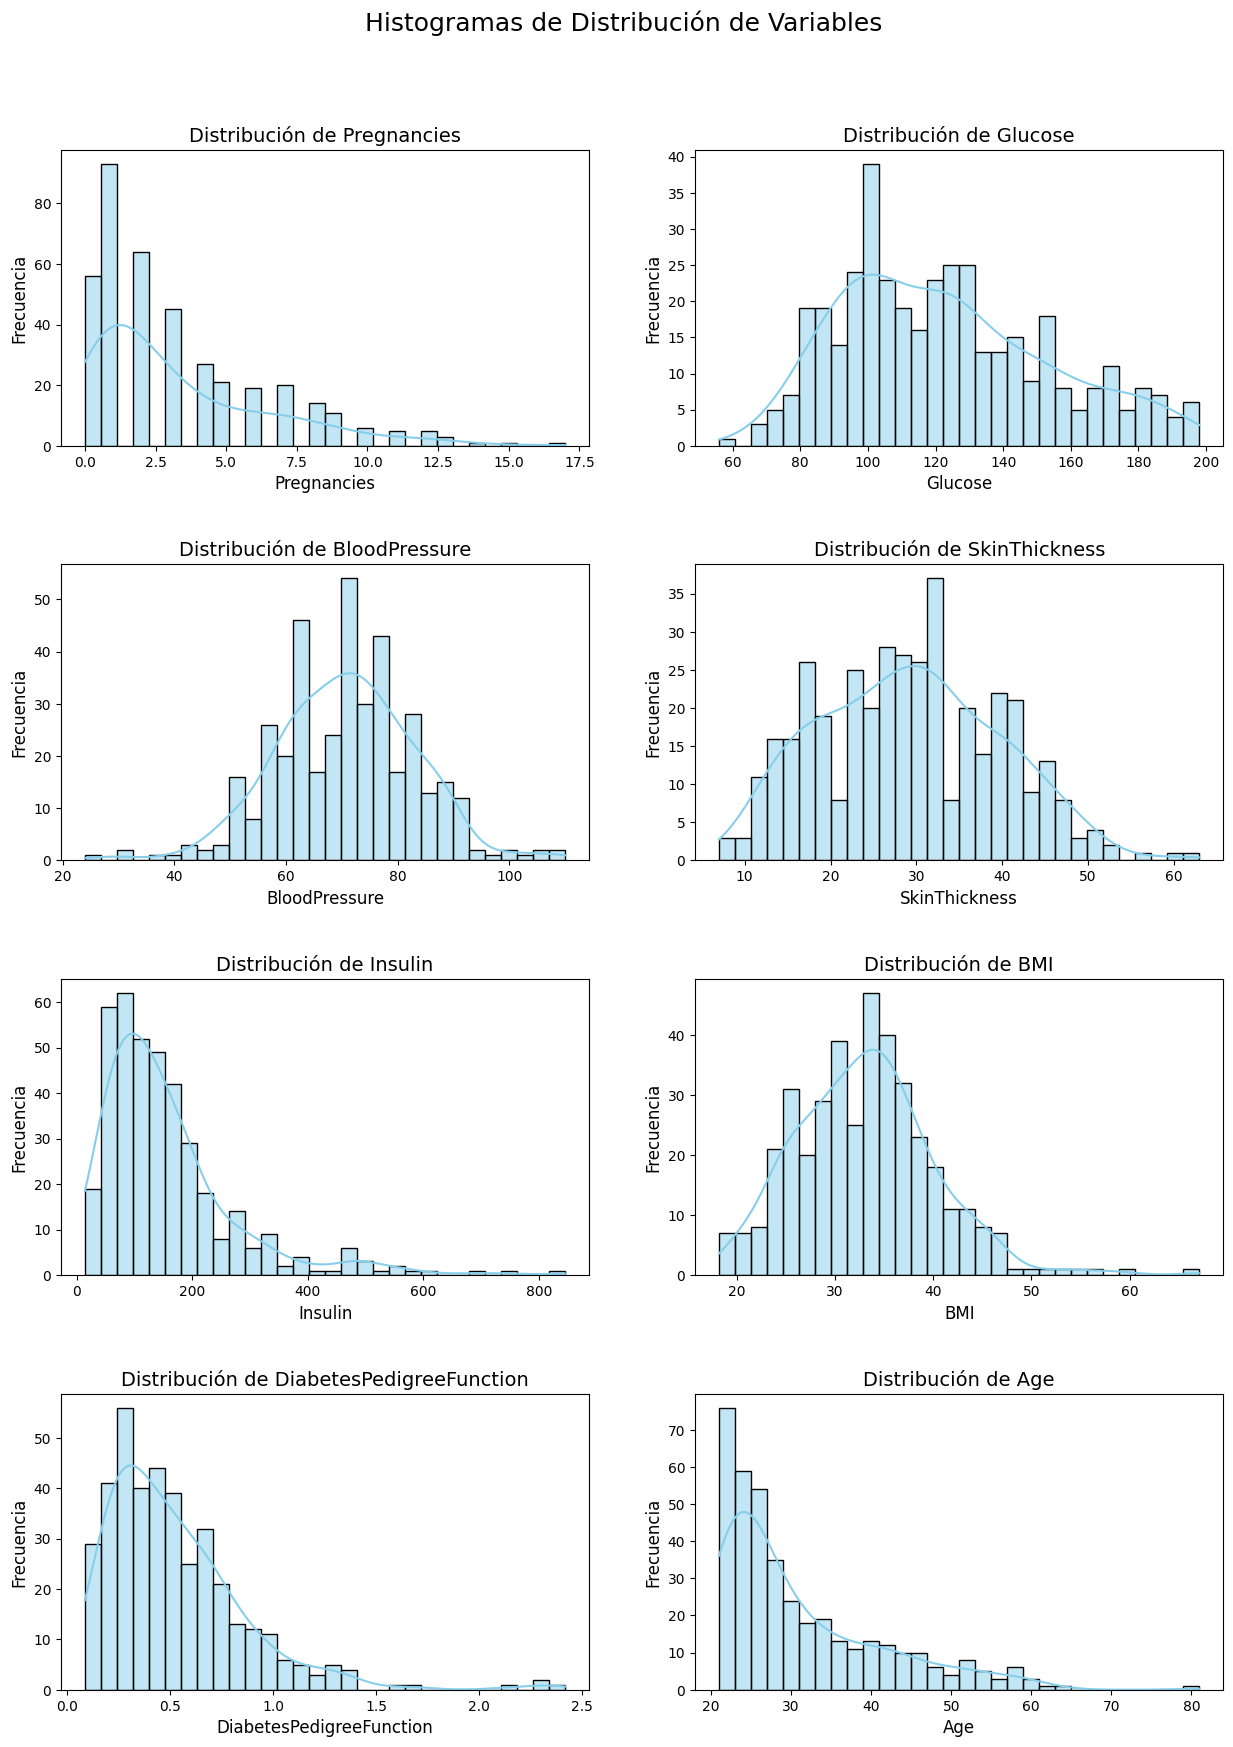

In [81]:
# Visualización de histogramas para todas las columnas numéricas excepto 'Outcome'

# 1. Definir las columnas a revisar (todas las numéricas, excepto 'Outcome')
# Incluimos 'Pregnancies' aunque pueda ser discreta, es útil ver su distribución.
columnas_numericas = ['Pregnancies', 'Glucose', 'BloodPressure', 
                      'SkinThickness', 'Insulin', 'BMI', 
                      'DiabetesPedigreeFunction', 'Age']

# 2. Configurar la visualización
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4)
axes = axes.flatten()

# 3. Iterar y dibujar los histogramas
for i, col in enumerate(columnas_numericas):
    sns.histplot(df_ini[col], bins=30, kde=True, ax=axes[i], 
                 edgecolor='black', color='skyblue')
    axes[i].set_title(f'Distribución de {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)

# 4. Mostrar el gráfico
plt.suptitle('Histogramas de Distribución de Variables', fontsize=18, y=0.95)
plt.show()

### observaciones:
Hay un alto de nº de registros con Pregnancies entre el 0 y 2, Glucose sobre el 100, BloodPresure sobre 

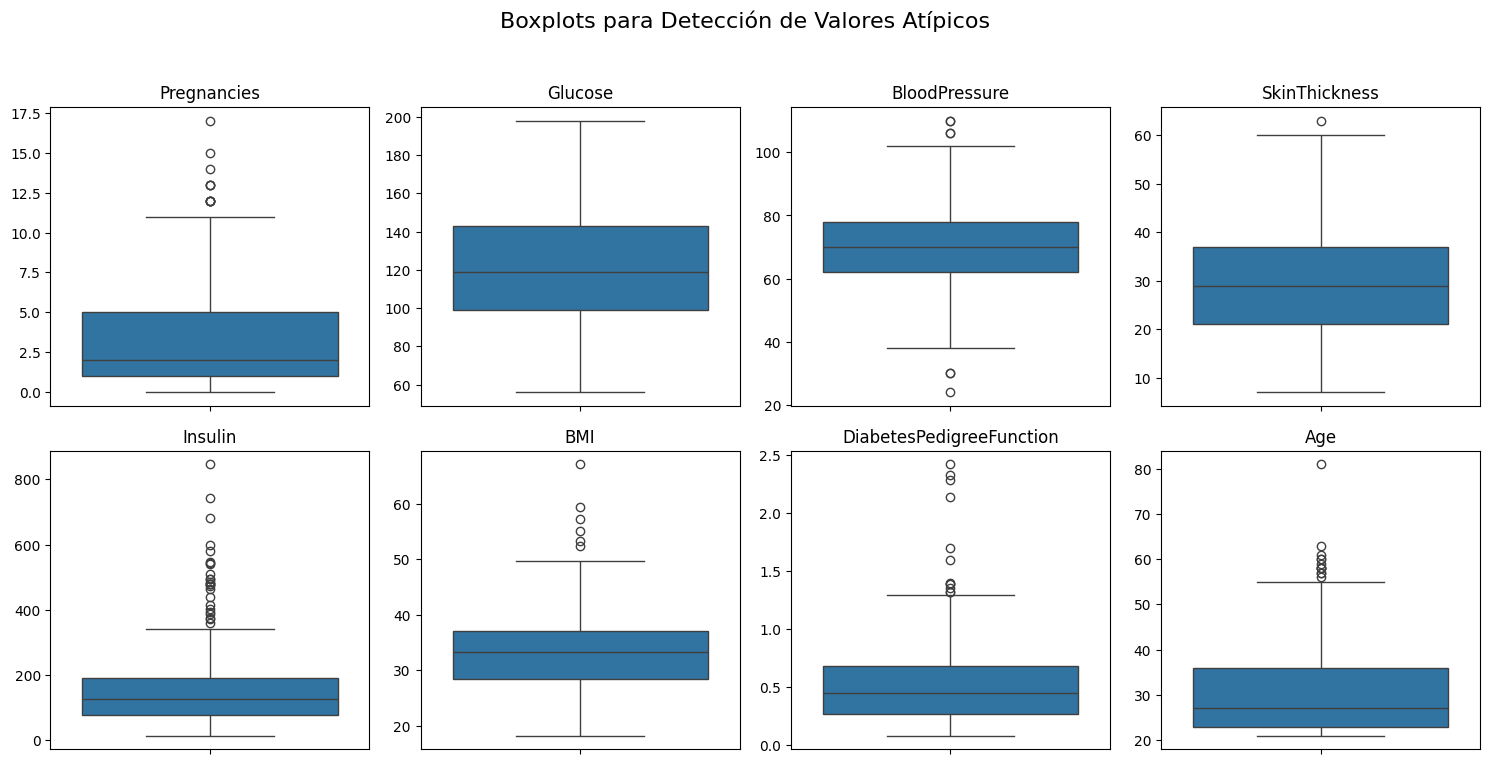

In [93]:
# Boxplots para detección de valores atípicos.

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8)) 
plt.subplots_adjust(hspace=0.4)

columnas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for i, col in enumerate(columnas):
    fila = i // 4  
    columna = i % 4 
    sns.boxplot(ax=axes[fila, columna], data=df_ini, y=col)
    axes[fila, columna].set_title(col)
    axes[fila, columna].set_ylabel('')
   
plt.suptitle('Boxplots para Detección de Valores Atípicos', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

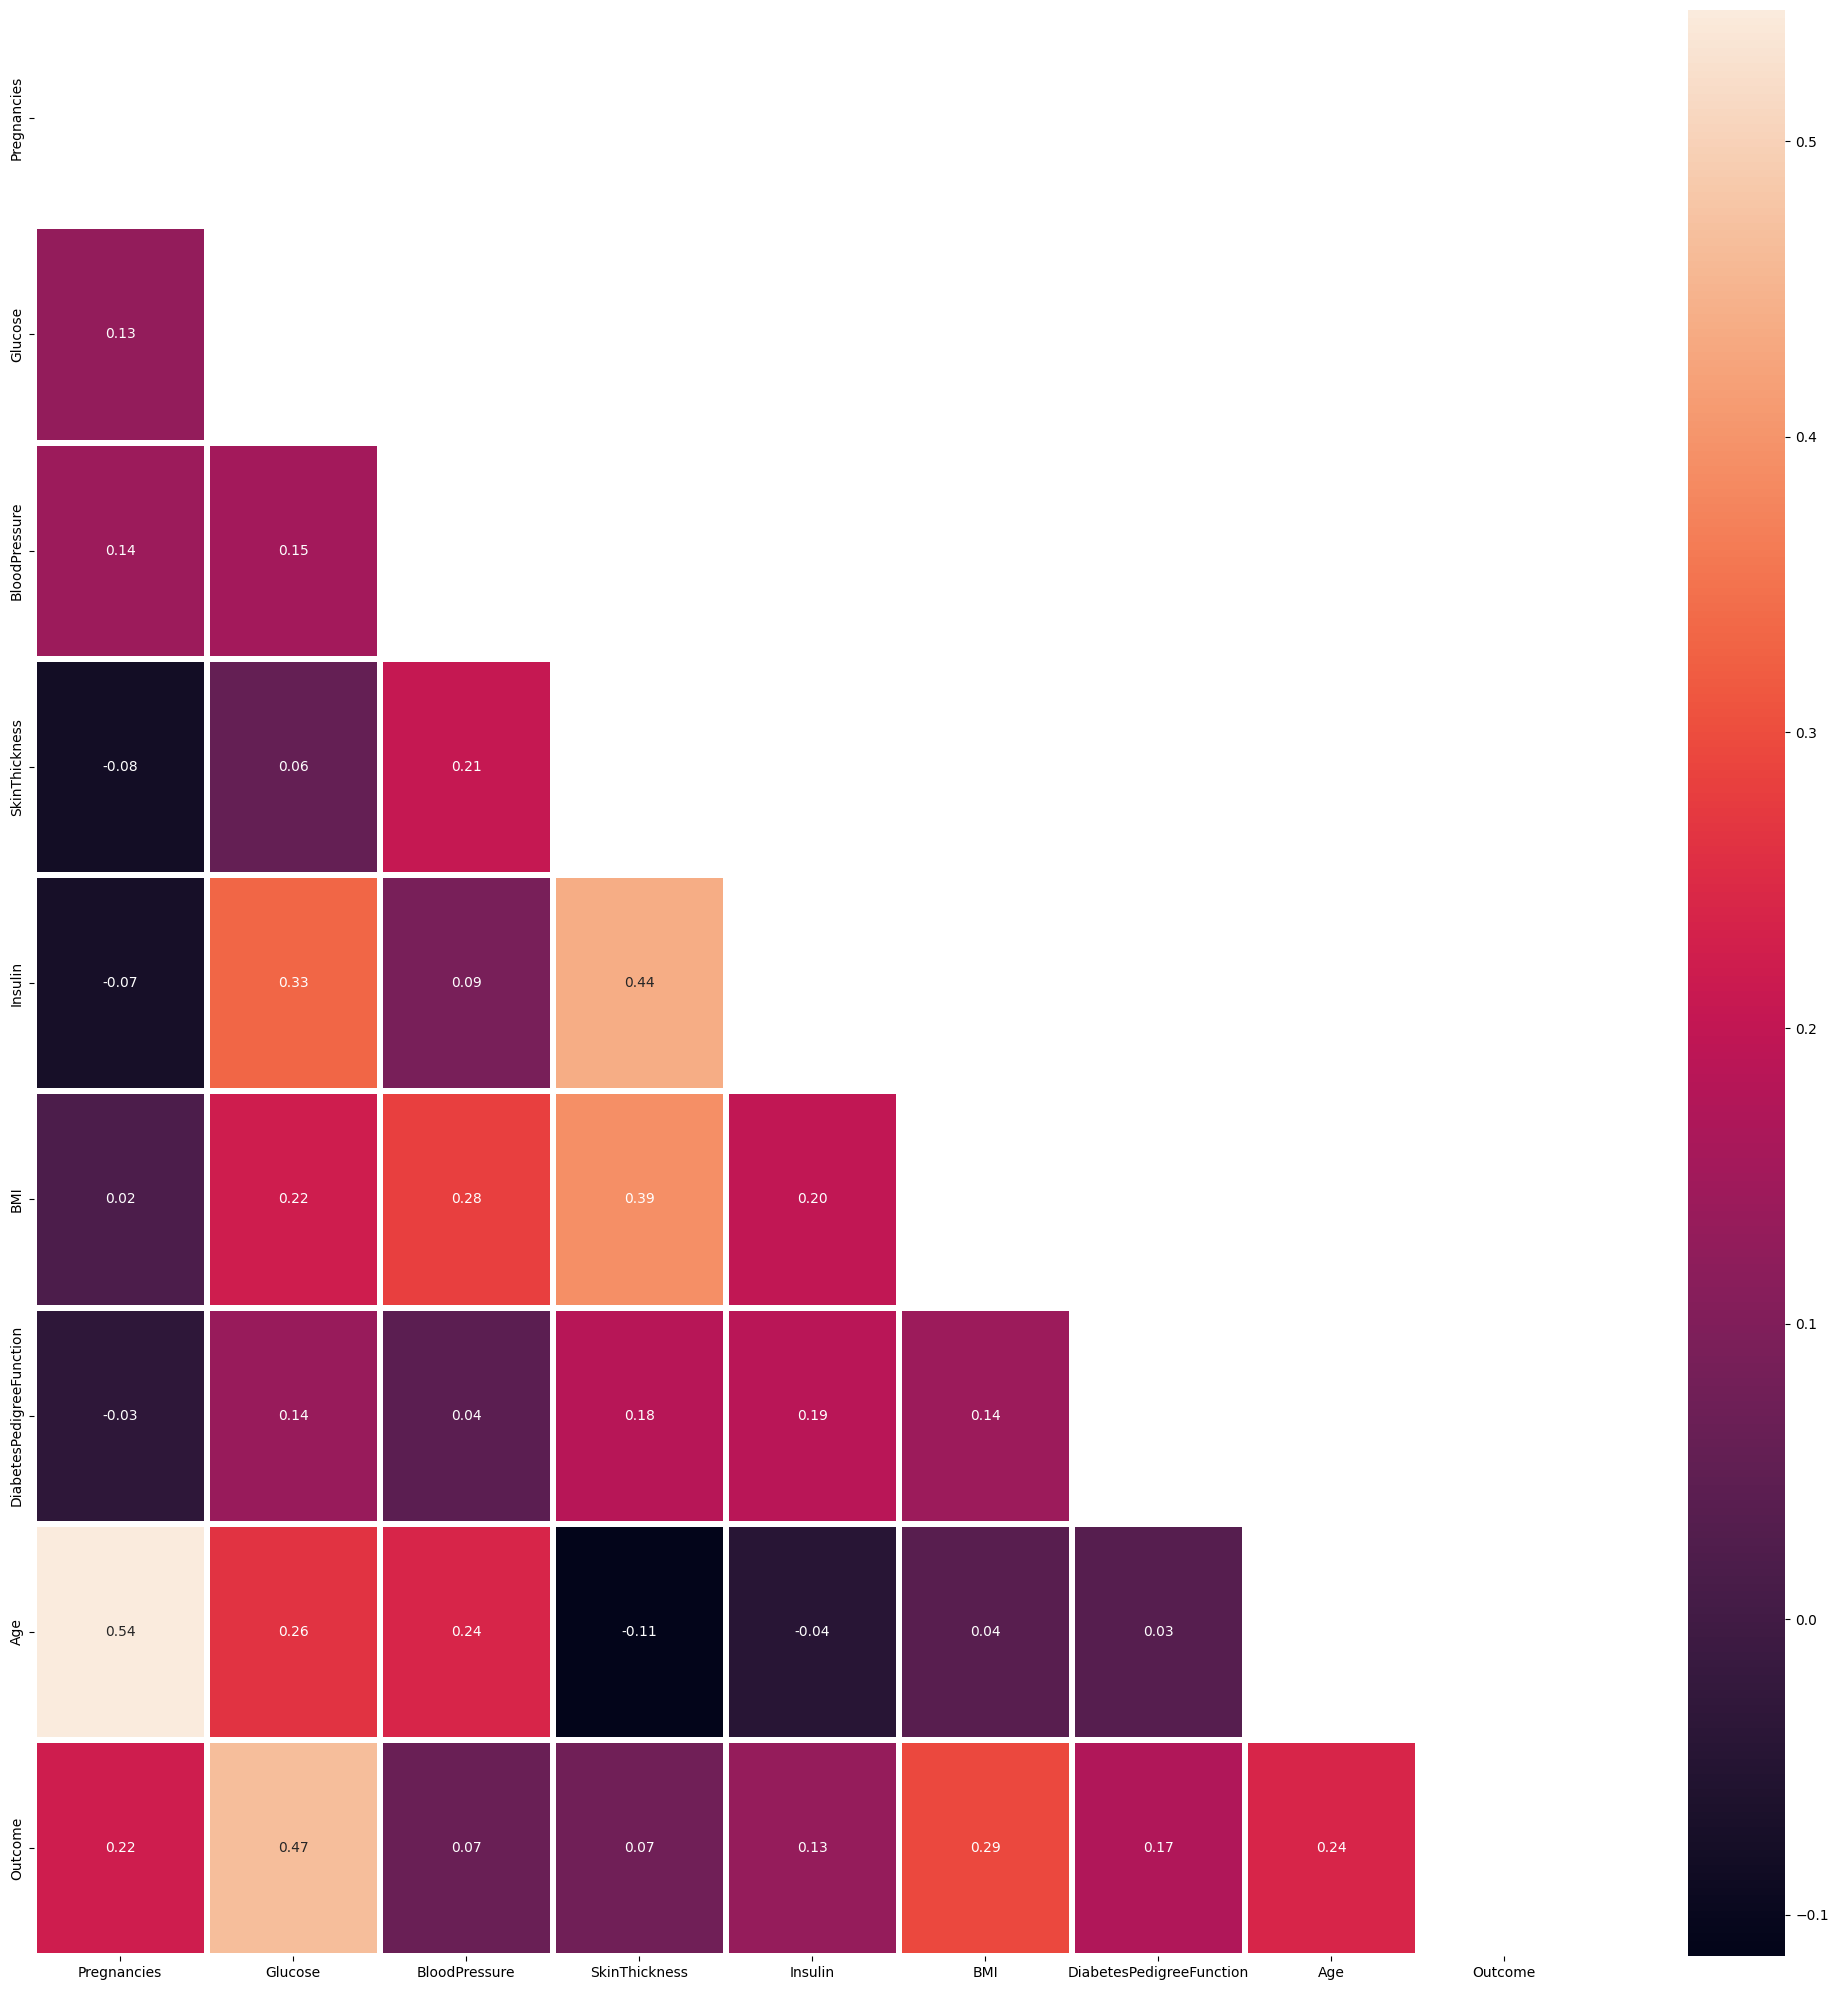

In [79]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axis = plt.subplots(figsize=(20,20))
sns.heatmap(corr, annot=True, mask=mask, linewidths=3, fmt=".2f")

plt.tight_layout()
plt.show()

> Creo mapa de calor de > de 0,40 para ver las más correlacionadas y eliminar más columnas.

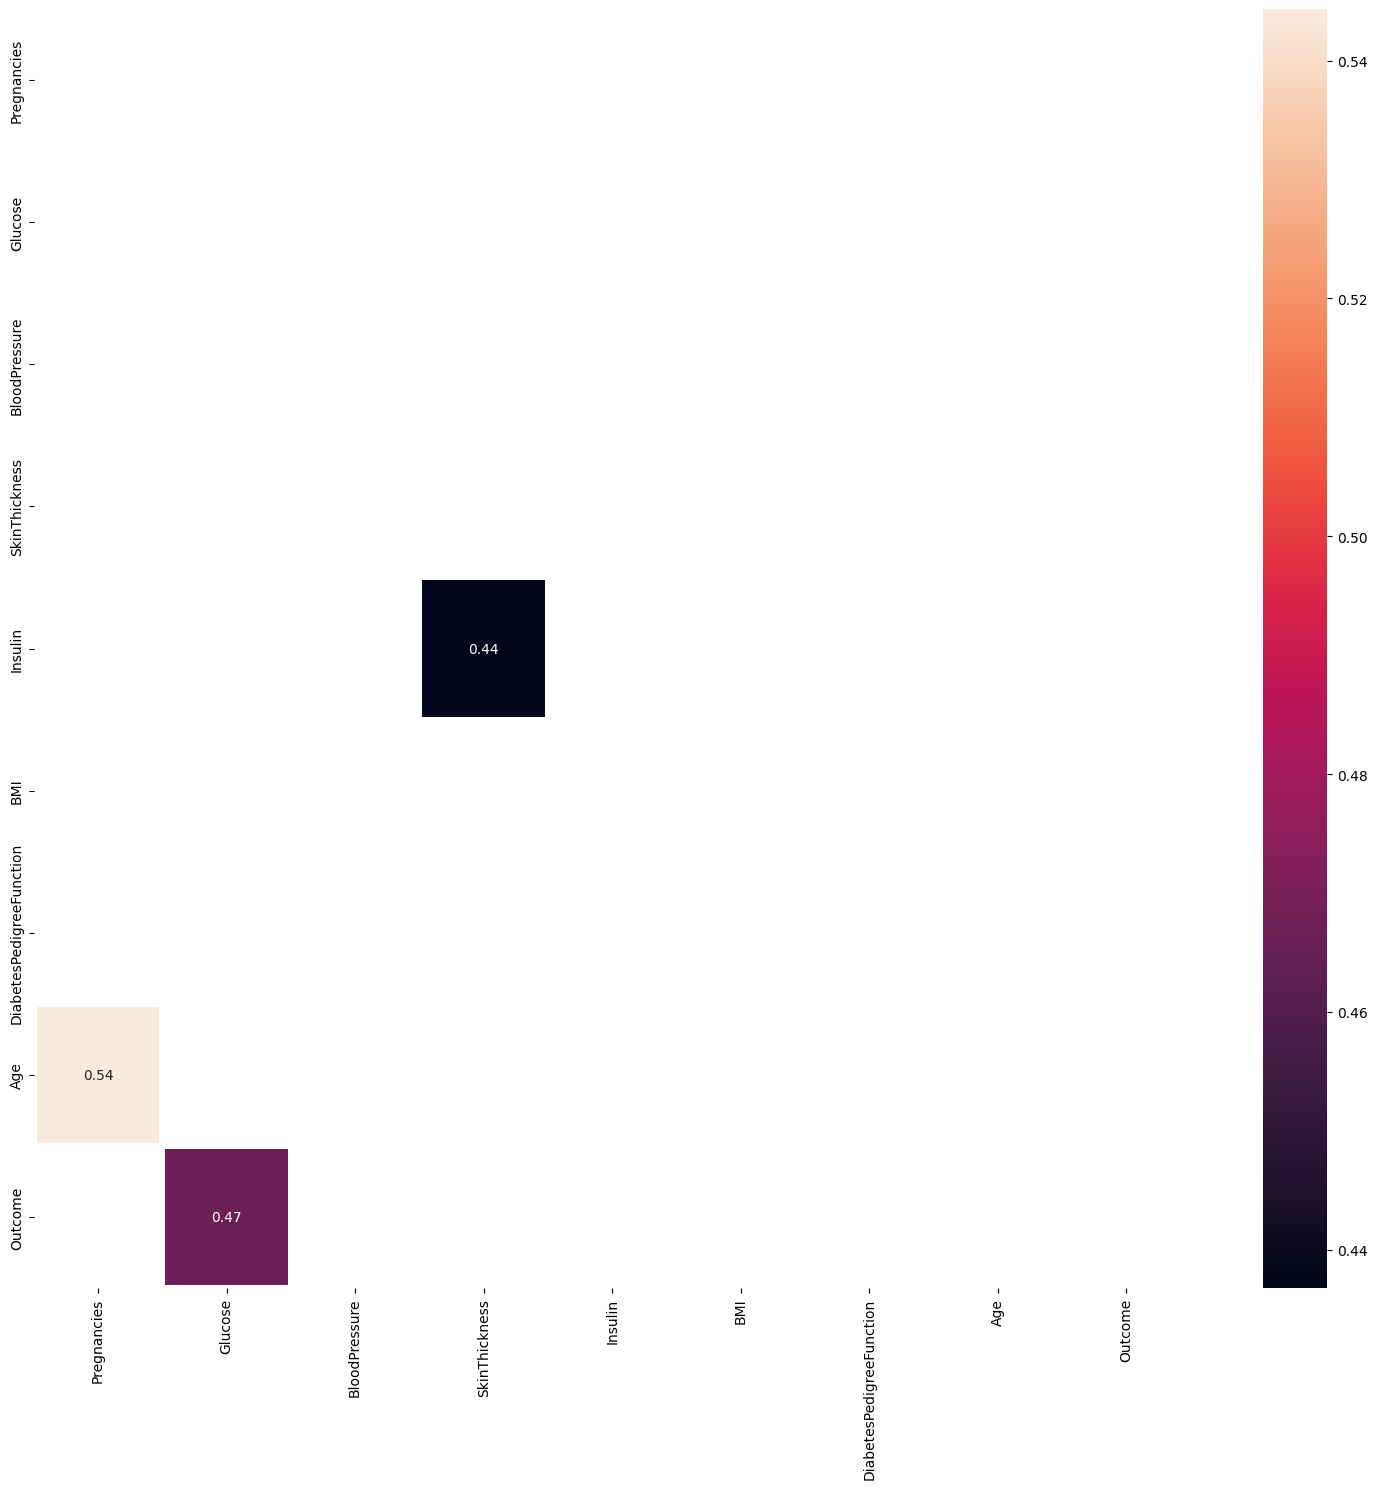

In [80]:
corr = df.corr()
high_correlation = corr[corr.abs() > 0.40]
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axis = plt.subplots(figsize=(15,15))
sns.heatmap(high_correlation, annot=True, mask=mask, linewidths=3, fmt=".2f")

plt.tight_layout()
plt.show()


> Dejo todas las columnas ya que creo que todas son importantes aunque la edad está relacionada al número de embarazos y la insulina con el grosor del pliegue cutaneo.